In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

SRC_FOLDER = 'formatted/dataset/'
FIGURE_FOLDER = 'figures/'

In [2]:
df_artists = pd.read_csv(SRC_FOLDER + 'artists.csv')#, nrows=SAMPLE)
df_tracks =  pd.read_csv(SRC_FOLDER + 'tracks.csv')#, nrows=SAMPLE)
df_playlists =  pd.read_csv(SRC_FOLDER + 'playlists.csv')#, nrows=SAMPLE)
df_playlists_tracks = pd.read_csv(SRC_FOLDER + 'playlist_tracks.csv')#, nrows=SAMPLE)

In [3]:
df_playlists_tracks

,playlist_id,track_id,artist_id,pos
0,967000,1,1,0
1,967000,2,1,1
2,967000,3,1,2
3,967000,4,2,3
4,967000,5,2,4
...,...,...,...,...
66346423,413999,203024,41507,7
66346424,413999,11789,1267,8
66346425,413999,50686,445,9
66346426,413999,2128,986,10


In [4]:
def reduce_size(dataframe):
    for col in dataframe.select_dtypes(include=[np.number]).columns:
        if pd.api.types.is_integer_dtype(dataframe[col]):
            dataframe[col] = pd.to_numeric(dataframe[col], downcast='integer')
        elif pd.api.types.is_float_dtype(dataframe[col]):
            dataframe[col] = pd.to_numeric(dataframe[col], downcast='float')
    return dataframe

In [5]:
df_artists = reduce_size(df_artists)
df_tracks = reduce_size(df_tracks)
df_playlists = reduce_size(df_playlists)
df_playlists_tracks = reduce_size(df_playlists_tracks)

In [6]:
df_artists.drop_duplicates(inplace=True)
df_tracks.drop_duplicates(inplace=True)

## Distribution of Unique Artists and Tracks per Playlist

In [7]:
unique_artists_per_playlist = df_playlists_tracks.groupby('playlist_id')['artist_id'].nunique()
unique_tracks_per_playlist = df_playlists_tracks.groupby('playlist_id')['track_id'].nunique()

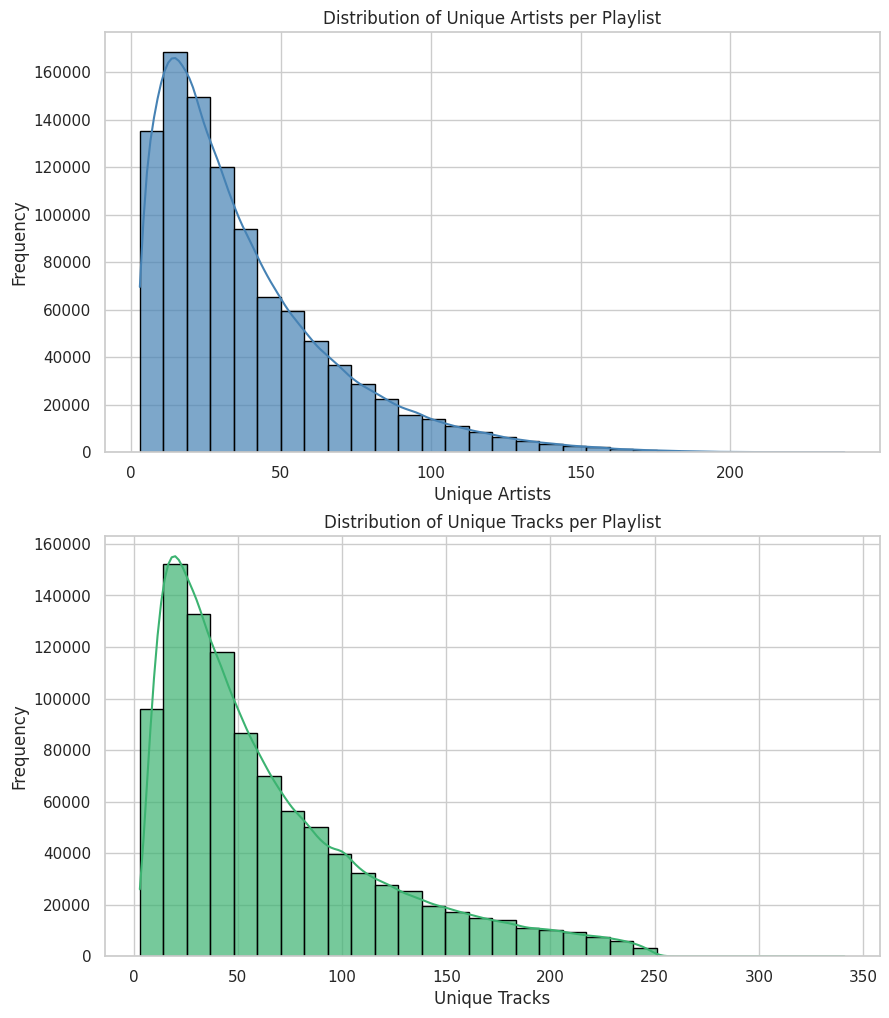

In [8]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 12))

plt.subplot(2, 1, 1)
sns.histplot(unique_artists_per_playlist, bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Unique Artists')
plt.ylabel('Frequency')
plt.title('Distribution of Unique Artists per Playlist')

plt.subplot(2, 1, 2)
sns.histplot(unique_tracks_per_playlist, bins=30, kde=True, color='mediumseagreen', edgecolor='black', alpha=0.7)
plt.title('Distribution of Unique Tracks per Playlist')
plt.xlabel('Unique Tracks')
plt.ylabel('Frequency')

plt.show()

## Artist Heterogeneity

In [9]:
def artist_heterogeneity(playlist_tracks):
    unique_artists = len(set(playlist_tracks['artist_id']))
    unique_tracks = len(set(playlist_tracks['track_id']))

    if unique_artists > 0:
        return np.log2(unique_tracks/unique_artists)
    else:
        return np.nan

In [10]:
# Sampling functions
def sample_first_n(playlist_tracks, num_sample):
    return playlist_tracks.head(num_sample)

def sample_random_n(playlist_tracks, num_sample):
    return playlist_tracks.sample(n=num_sample, random_state=666) if len(playlist_tracks) > 30 else playlist_tracks

def sample_all(playlist_tracks):
    return playlist_tracks

In [34]:
# Group by playlist and calculate artist heterogeneity for each sampling method
playlist_groups = df_playlists_tracks.groupby('playlist_id')
filtered_playlists = playlist_groups.filter(lambda x: len(x) >= 50)
filtered_playlists['playlist_id'].nunique()

496451

In [35]:
playlist_ids = filtered_playlists['playlist_id'].unique()
sampled_playlist_ids =  pd.Series(playlist_ids).sample(n=5000, random_state=666)
sampled_filtered_playlists = filtered_playlists[filtered_playlists['playlist_id'].isin(sampled_playlist_ids)]

In [36]:
# Calculate artist heterogeneity for each sampling method on filtered playlists
heterogeneity_first_n = sampled_filtered_playlists.groupby('playlist_id').apply(lambda x: artist_heterogeneity(sample_first_n(x, num_sample=30))).reset_index()
heterogeneity_first_n.columns = ['playlist_id', 'First 30 Tracks']
heterogeneity_random_n = sampled_filtered_playlists.groupby('playlist_id').apply(lambda x: artist_heterogeneity(sample_random_n(x, num_sample=30))).reset_index()
heterogeneity_random_n.columns = ['playlist_id', 'Random 30 Tracks']
heterogeneity_all = sampled_filtered_playlists.groupby('playlist_id').apply(lambda x: artist_heterogeneity(sample_all(x))).reset_index()
heterogeneity_all.columns = ['playlist_id', 'All Tracks']


/tmp/ipykernel_1808/4117160587.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heterogeneity_first_n = sampled_filtered_playlists.groupby('playlist_id').apply(lambda x: artist_heterogeneity(sample_first_n(x, num_sample=30))).reset_index()
/tmp/ipykernel_1808/4117160587.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heterogeneity_random_n = sampled_filtered_playlists.groupby('playlist_id').apply(lam

In [37]:
df_heterogeneity = heterogeneity_first_n.merge(heterogeneity_random_n, on='playlist_id') \
                                        .merge(heterogeneity_all, on='playlist_id')

/tmp/ipykernel_1808/60532165.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Sampling Method', y='Artist Heterogeneity', data=df_melted, palette='Set2', inner='quartile')


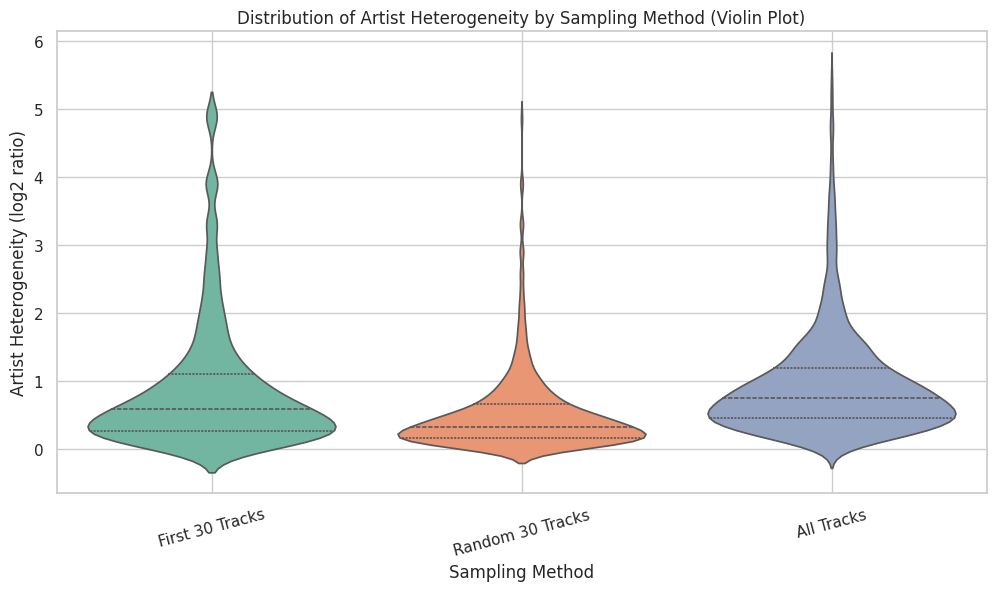

In [39]:
df_melted = df_heterogeneity.melt(id_vars='playlist_id', var_name='Sampling Method', value_name='Artist Heterogeneity')

plt.figure(figsize=(12, 6))
sns.violinplot(x='Sampling Method', y='Artist Heterogeneity', data=df_melted, palette='Set2', inner='quartile')
plt.title('Distribution of Artist Heterogeneity by Sampling Method')
plt.ylabel('Artist Heterogeneity (log2 ratio)')
plt.xlabel('Sampling Method')
plt.xticks(rotation=15)
plt.grid(True)
plt.show()